In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import font_manager
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib.markers import MarkerStyle

warnings.filterwarnings('ignore')
plt.rcParams.update({"font.size": 10})
plt.rcParams.update({"axes.titlesize": 10})
plt.rcParams["font.family"] = "serif"
uparrow=f"\u2191"
downarrow=f"\u2193"
ours_mode_alpha = 0.8
ablation_alpha = 0.4

dataset_names = ["ImageNet","ImageNet V2","iWildCam", "iWildCam OOD", "Caltech 256"]
datasets = ["imagenet","imagenet_ood","iwildcam", "iwildcam_ood", "caltech256"]
prefix_single_model = "cleaned/evaluation_single_model" # evaluation_single_model
single_model_dfs = [pd.read_csv(f"{prefix_single_model}_{dataset}.csv") for dataset in datasets]

In [2]:
import matplotlib.colors as mcolors

def brighten(color, factor=1.2):
    rgb = mcolors.to_rgb(color)
    bright = tuple(min(1, c * factor) for c in rgb)
    return bright

base_palette = sns.color_palette("pastel")
muted_pastel = [brighten(c, factor=0.9) for c in base_palette]

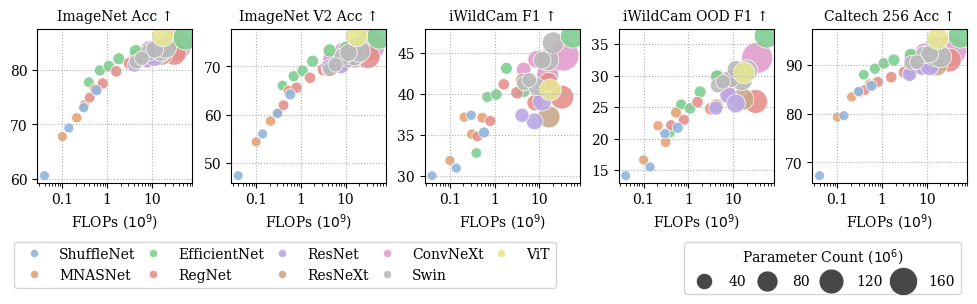

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2), sharey=False, sharex=False, constrained_layout = False)
fig.subplots_adjust(wspace=0.25) 
axes = axes.flatten()
metric_scale=100

architecture_order = single_model_dfs[0].sort_values("gflops")["architecture"].unique()
# print(architecture_order)
metric_names = ["Acc", "Acc", "F1", "F1", "Acc"]


for i, (df, metric, name) in enumerate(zip(single_model_dfs, metric_names, dataset_names)):
    metric_scaled_colname = metric+"_scaled"
    df[metric_scaled_colname]=df[metric]*metric_scale
    sns.scatterplot(
        data=df,
        x="gflops",
        y=metric_scaled_colname,
        hue="architecture",
        hue_order=architecture_order,
        size="Params",
        sizes=(50, 500),
        ax=axes[i],
        legend=(i == 0),
        palette=muted_pastel,
        alpha=0.9
    )

    axes[i].set_title(name+f" {metric} {uparrow}")
    axes[i].set_xlabel("FLOPs ($10^9$)")
    axes[i].set_ylabel(f"")
    axes[i].set_xscale("log")
    axes[i].grid(True, linestyle=':')

for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:g}"))
# Extract and remove default legend
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()

# Separate handles/labels using set logic
arch_handles, arch_labels = [], []
size_handles, size_labels = [], []

arch_handles = handles[1:len(architecture_order)+1]
arch_labels = labels[1:len(architecture_order)+1]

size_handles = handles[len(architecture_order)+2:]
size_labels = labels[len(architecture_order)+2:]


# Place legends in the lower right
fig.legend(arch_handles, arch_labels, title="", loc="upper left", bbox_to_anchor=(0.1, -0.15), ncol=5, columnspacing=0.3)
fig.legend(size_handles, size_labels, title="Parameter Count ($10^6$)", loc="upper right", bbox_to_anchor=(0.9, -0.15), ncol=4,columnspacing=0.5)


plt.savefig("pdf/Transferability.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
prefix_duo="cleaned/evaluation_duo"
duo_dfs = [pd.read_csv(f"{prefix_duo}_{dataset}.csv") for dataset in datasets]

In [5]:
pal = sns.color_palette("Set2",8)
display(pal)

tempered_duo_hue = pal[1]
unweighted_duo_hue = pal[2]
uqonly_duo_hue = pal[0]

baseline_hue = "firebrick"
baseline_width = 1.5
baseline_style="dashed"

prefix_duo="cleaned/evaluation_duo"
duo_dfs = [pd.read_csv(f"{prefix_duo}_{dataset}.csv") for dataset in datasets]
large_models = ["vit_base_patch16_clip_224.laion2b_ft_in12k_in1k","ConvNeXt_Base","tf_efficientnetv2_l.in21k_ft_in1k","tf_efficientnetv2_l.in21k_ft_in1k","Swin_V2_B"]
large_model_names = ["ViT-B Clip", "ConvNext-B", "EfficientNet-V2-L","EfficientNet-V2-L", "Swin-V2-B"]
# mode_order = ['Duo: Unweighted', 'Duo: UQ Only', 'Duo: Ours']
scatterplot_point_order_btf = ["Duo: Unweighted", "Duo: UQ Only","Duo: Ours"] # background to foreground

mode_order = ['Duo: Ours','Duo: UQ Only','Duo: Unweighted']

# mode_shape_map = {m:s for (m,s) in zip(mode_order,["X","P","h"])}
ablation_mark_style = MarkerStyle(marker='o',fillstyle="none")
mode_shape_map = {m:s for (m,s) in zip(mode_order,["o","o","o"])} # o,o,o
mode_size_order = {m:s for (m,s) in zip(mode_order,[40,40,40])}
mode_color_map = {m:c for (m,c) in zip(mode_order,[tempered_duo_hue,uqonly_duo_hue,unweighted_duo_hue])}
mode_order_map = {m:i for (i,m) in enumerate(scatterplot_point_order_btf)}


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [6]:
ours_mode_name="Duo: Ours"
def plot_single_dataset(ax, df, dataset_name, f_large, f_large_name,
                        metric, metric_display_name, arrow, scale_metric,
                        x, mode_order_map, mode_color_map, mode_shape_map,
                        mode_size_order, duo_modes, annotate_xy,
                        baseline_hue, baseline_width,
                        is_first):

    # Filter and prepare data
    filtered_df = df[df["model_large"] == f_large].copy()
    filtered_df = filtered_df[filtered_df["mode"].isin(duo_modes)].copy()
    filtered_df = filtered_df.sort_values(by="mode", key=lambda col: col.map(mode_order_map))
    filtered_df[metric] *= scale_metric
    modes_in_data = filtered_df["mode"].unique()
    sns.scatterplot(
        data=filtered_df[filtered_df["mode"] != ours_mode_name],
        x=x, y=metric,
        hue="mode",
        palette=mode_color_map,
        legend=is_first,
        marker='o',
        ax=ax,
        alpha=ablation_alpha,
        size="mode",
        sizes=mode_size_order,
    )
    sns.scatterplot(
        data=filtered_df[filtered_df["mode"] == ours_mode_name],
        x=x, y=metric,
        hue="mode",
        palette=mode_color_map,
        legend=is_first,
        ax=ax,
        alpha=ours_mode_alpha,
        size="mode",
        sizes=mode_size_order,    
    )
    
    ax.set_title(f"{dataset_name} {metric_display_name} {arrow}")
    ax.set_xlabel("FLOPs Balance")
    ax.set_ylabel("")
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.tick_params(axis='x', labelsize=9)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}" if x == int(x) else f"{x:.2f}"))
    ax.grid(True, linestyle=':', axis="x")
    ax.set_xlim(-0.1, 1)
    if min(filtered_df[metric])>10:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4,integer=True))
    else:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}" if y >= 10 else f"{y:.1f}"))
    
    # Annotate architecture
    ax.annotate(
        f"{f_large_name}",
        xy=annotate_xy, xycoords='axes fraction',
        ha='right', fontsize=9, bbox=None
    )

    # Draw baseline
    baseline_colname = f"{metric}_baseline"
    baseline_values = filtered_df[baseline_colname].unique()
    if len(baseline_values) != 1:
        print(filtered_df[baseline_colname].unique())
        raise RuntimeError("More than one baseline value found.")
    baseline = baseline_values[0] * scale_metric
    ax.axhline(y=baseline, color=baseline_hue, linestyle='dashed', linewidth=baseline_width)
    
    # Pad if baseline is the worst value
    ymin, ymax = ax.get_ylim()
    yrange=ymax-ymin
    min_val = filtered_df[metric].min()
    max_val = filtered_df[metric].max()
    y_padding = 0.15 * yrange
    if baseline < min_val+0.1*yrange:
        ax.set_ylim(ymin - y_padding, ymax)
    if baseline > max_val-0.1*yrange:
        ax.set_ylim(ymin, ymax+y_padding)
    
    return ax, set(modes_in_data)

def plot_all_datasets(duo_dfs, dataset_names, large_models, large_model_names,
                      metrics, metric_display_names, arrow_list,
                      scale_metric, x, duo_modes, mode_order_map,
                      mode_color_map, mode_shape_map, mode_size_order,
                      annotate_xy, baseline_hue, baseline_width,
                      figsize=(12, 1.7), wspace=0.25):

    fig, axes = plt.subplots(1, len(duo_dfs), figsize=figsize, sharey=False, sharex=False)
    fig.subplots_adjust(wspace=wspace)
    axes = axes.flatten()

    all_modes = set()

    for i, (df, dataset_name, f_large, f_large_name, metric, metric_display_name, arrow) in enumerate(
        zip(duo_dfs, dataset_names, large_models, large_model_names, metrics, metric_display_names, arrow_list)
    ):
        is_first = (i == 0)
        ax, modes_in_data = plot_single_dataset(
            axes[i], df, dataset_name, f_large, f_large_name,
            metric, metric_display_name, arrow, scale_metric,
            x, mode_order_map, mode_color_map, mode_shape_map,
            mode_size_order, duo_modes, annotate_xy,
            baseline_hue, baseline_width,
            is_first=is_first
        )
        all_modes.update(modes_in_data)

    handles, labels = axes[0].get_legend_handles_labels()
    filtered_handles_labels = [(h, l) for mode in duo_modes for h, l in zip(handles, labels)if l == mode]
    
    hue_handles, hue_labels = zip(*filtered_handles_labels)
    baseline_line = Line2D([0], [0], color=baseline_hue, linestyle='dashed', linewidth=baseline_width)
    hue_handles += (baseline_line,)
    hue_labels += ("Base Model",)

    fig.legend(
        hue_handles, hue_labels,
        title="",
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(hue_handles),
        labelspacing=0.5
    )
    
    if (scale_metric!=1) and len(set(large_models))==1:
        fig.text(
            x=0.9,
            y=-0.2,
            s=f"{metric_display_name} scaled by {int(scale_metric)} for legibility.",
            ha='right', 
            va='top',
            fontsize=8,
            color="gray"
        )
    
    if axes[0].get_legend() is not None:
        axes[0].get_legend().remove()

    return fig


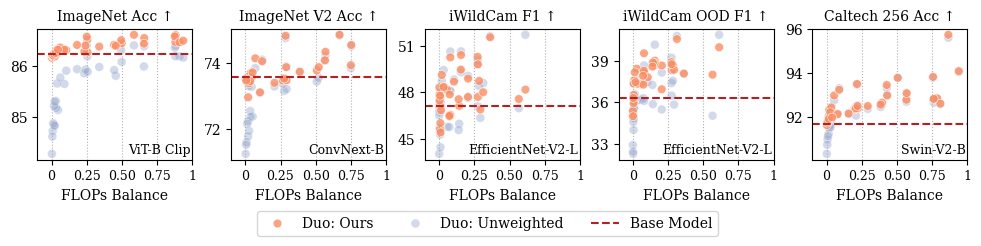

In [7]:
fig = plot_all_datasets(
    duo_dfs=duo_dfs,
    dataset_names=dataset_names,
    large_models=large_models,
    large_model_names=large_model_names,
    metrics=["Acc","Acc","F1","F1","Acc"],
    metric_display_names=["Acc","Acc","F1","F1","Acc"],
    arrow_list=[uparrow]*5,
    scale_metric=100,
    x="gflops_balance",
    duo_modes=['Duo: Ours','Duo: Unweighted'],
    mode_order_map=mode_order_map,
    mode_color_map=mode_color_map,
    mode_shape_map=mode_shape_map,
    mode_size_order=mode_size_order,
    annotate_xy=(0.99, 0.05),
    baseline_hue=baseline_hue,
    baseline_width=baseline_width,
)
fig.savefig("pdf/Accuracy.pdf",bbox_inches="tight")


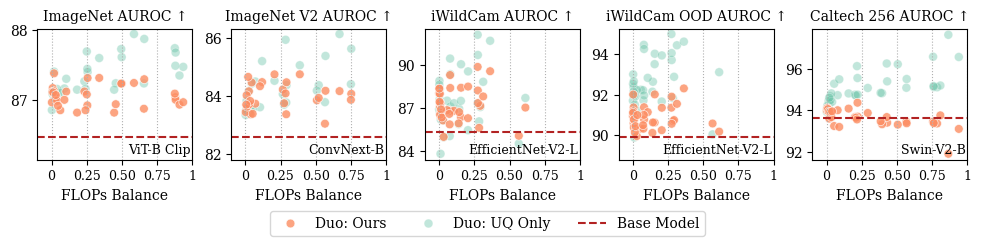

In [8]:
fig = plot_all_datasets(
    duo_dfs=duo_dfs,
    dataset_names=dataset_names,
    large_models=large_models,
    large_model_names=large_model_names,
    metrics=["CP_AUROC"]*5,
    metric_display_names=["AUROC"]*5,
    arrow_list=[uparrow]*5,
    scale_metric=100,
    x="gflops_balance",
    duo_modes=['Duo: Ours','Duo: UQ Only'],
    mode_order_map=mode_order_map,
    mode_color_map=mode_color_map,
    mode_shape_map=mode_shape_map,
    mode_size_order=mode_size_order,
    annotate_xy=(0.99, 0.05),
    baseline_hue=baseline_hue,
    baseline_width=baseline_width
)
fig.savefig("pdf/AUROC.pdf",bbox_inches="tight")

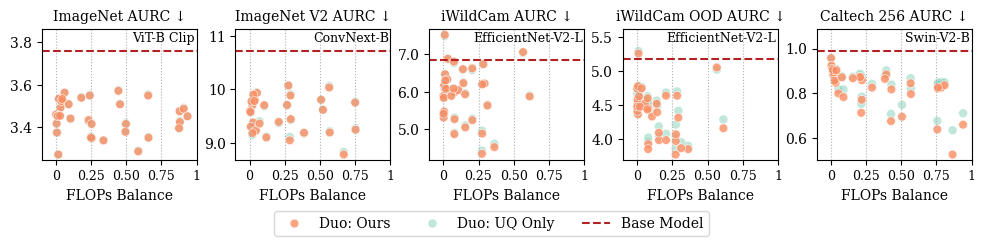

In [9]:
fig = plot_all_datasets(
    duo_dfs=duo_dfs,
    dataset_names=dataset_names,
    large_models=large_models,
    large_model_names=large_model_names,
    metrics=["AURC"]*5,
    metric_display_names=["AURC"]*5,
    arrow_list=[downarrow]*5,
    scale_metric=100,
    x="gflops_balance",
    duo_modes=['Duo: Ours','Duo: UQ Only'],
    mode_order_map=mode_order_map,
    mode_color_map=mode_color_map,
    mode_shape_map=mode_shape_map,
    mode_size_order=mode_size_order,
    annotate_xy=(0.99, 0.90),
    baseline_hue=baseline_hue,
    baseline_width=baseline_width
)
fig.savefig("pdf/AURC.pdf",bbox_inches="tight")

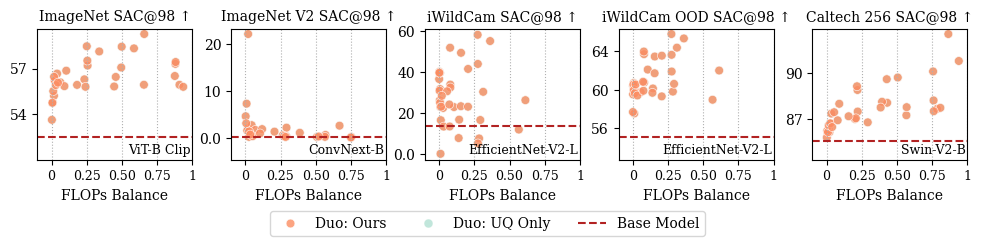

In [10]:
fig = plot_all_datasets(
    duo_dfs=duo_dfs,
    dataset_names=dataset_names,
    large_models=large_models,
    large_model_names=large_model_names,
    metrics=["SAC@98"]*5,
    metric_display_names=["SAC@98"]*5,
    arrow_list=[uparrow]*5,
    scale_metric=100,
    x="gflops_balance",
    duo_modes=['Duo: Ours','Duo: UQ Only'],
    mode_order_map=mode_order_map,
    mode_color_map=mode_color_map,
    mode_shape_map=mode_shape_map,
    mode_size_order=mode_size_order,
    annotate_xy=(0.99, 0.05),
    baseline_hue=baseline_hue,
    baseline_width=baseline_width
)
fig.savefig("pdf/SAC@98.pdf",bbox_inches="tight")

# Soup Plots

Adusting ylim max
Adusting ylim min
Adusting ylim max
Adusting ylim max
Adusting ylim min
Adusting ylim max
mode_order=['Duo: Ours', 'Duo: UQ Only', 'Duo: Unweighted']
deduped=OrderedDict([('Duo: Unweighted', <matplotlib.lines.Line2D object at 0x175fb7b50>), ('Duo: Ours', <matplotlib.lines.Line2D object at 0x1760e54d0>), ('Duo: UQ Only', <matplotlib.lines.Line2D object at 0x176108250>)])


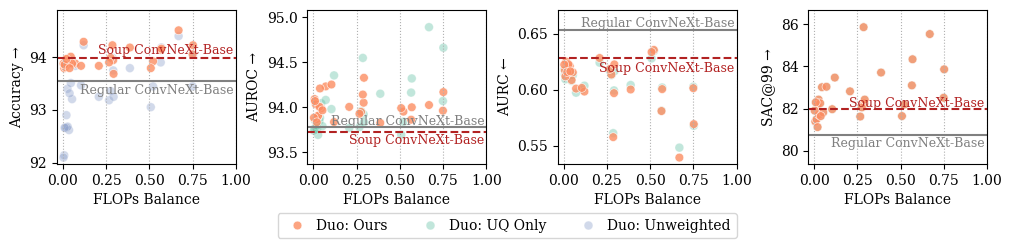

In [11]:

# Metrics with desired direction
metrics = [("Acc", "\u2192"), ("CP_AUROC", "\u2192"), ("AURC", "\u2190"), ("SAC@99", "\u2192")]
metric_display_names = ["Accuracy","AUROC","AURC","SAC@99"]

# Modes to exclude per subplot
# included_modes=[["Duo: Ours"],["Duo: Ours"],["Duo: Ours"],["Duo: Ours"]]
included_modes=[["Duo: Ours","Duo: Unweighted"],
                ["Duo: Ours","Duo: UQ Only"],
                ["Duo: Ours","Duo: UQ Only"],
                ["Duo: Ours","Duo: UQ Only"]]


base_model="ConvNeXt_Base"
soup_model="ConvNeXt_Base_greedy"

# Plot setup
fig, axes = plt.subplots(1, len(metrics), figsize=(12, 2), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.4)
axes = axes.flatten()

caltech_duo_df = pd.read_csv("cleaned/evaluation_duo_caltech256.csv")
caltech_single_df = pd.read_csv("cleaned/evaluation_single_model_caltech256.csv")


vanilla_baseline_color="gray"
soup_baseline_color=baseline_hue

for i, ((metric, arrow),metric_display_name) in enumerate(zip(metrics,metric_display_names)):
    ax = axes[i]

    # Filter data
    df_plot = caltech_duo_df[caltech_duo_df["mode"].isin(included_modes[i])].copy()
    metric_perc = metric + "_perc"
    df_plot[metric_perc] = df_plot[metric] * metric_scale
    df_plot = df_plot[df_plot["model_large"] == soup_model]
    # Scatter plot
    
    # Ablation
    sns.scatterplot(
        data=df_plot[df_plot["mode"]!=ours_mode_name],
        x="gflops_balance",
        y=metric_perc,
        hue="mode",
        style="mode",
        markers=mode_shape_map,
        size="mode",
        sizes=mode_size_order,
        alpha=ablation_alpha,
        palette=mode_color_map,
        ax=ax,
        legend=(i < 2),
    )
    
    sns.scatterplot(
        data=df_plot[df_plot["mode"]==ours_mode_name],
        x="gflops_balance",
        y=metric_perc,
        hue="mode",
        style="mode",
        markers=mode_shape_map,
        size="mode",
        sizes=mode_size_order,
        alpha=ours_mode_alpha,
        palette=mode_color_map,
        ax=ax,
        legend=(i < 2),
    )
    
    baseline_vanilla = caltech_single_df[
        (caltech_single_df["model"] == base_model)
    ].copy()
    baseline_vanilla[metric_perc] = baseline_vanilla[metric] * metric_scale
    
    # Vanilla Single Model Baseline
    y_baseline_vanilla = baseline_vanilla[metric_perc].values[0]
    ax.axhline(y_baseline_vanilla, color=vanilla_baseline_color, linestyle="solid", linewidth=baseline_width)
    baseline_soup = caltech_single_df[
        (caltech_single_df["model"] == soup_model)
    ].copy()
    baseline_soup[metric_perc] = baseline_soup[metric] * metric_scale
    y_baseline_soup = baseline_soup[metric_perc].values[0]
    ax.axhline(y_baseline_soup, color=soup_baseline_color, linestyle="--", linewidth=baseline_width)
    
    # Pad low or top
    min_val = df_plot[metric_perc].min()
    max_val = df_plot[metric_perc].min()
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    if (y_baseline_vanilla < min_val+yrange*0.1) or (y_baseline_soup < min_val+yrange*0.1):
        print("Adusting ylim min")
        ymin = ymin - yrange*0.2
    if (y_baseline_vanilla > max_val-yrange*0.1) or (y_baseline_soup  > max_val-yrange*0.1):
        print("Adusting ylim max")
        ymax = ymax + yrange*0.1
        
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.set_ylim(ymin, ymax)
    
    base_model_display_name=base_model.replace("_","-")
    if (y_baseline_vanilla<y_baseline_soup):
        y_baseline_vanilla_print = y_baseline_vanilla-0.07*yrange
        y_baseline_soup_print = y_baseline_soup+0.05*yrange
    else:
        y_baseline_vanilla_print = y_baseline_vanilla+0.05*yrange
        y_baseline_soup_print = y_baseline_soup-0.07*yrange
    ax.text(
        x=0.13, y=y_baseline_vanilla_print,
        s=f"Regular {base_model_display_name}", color=vanilla_baseline_color,
        fontsize=9, va="center", transform=ax.get_yaxis_transform()
    )
    # Add Greedy Soup baseline
    ax.text(
        x=0.23, y=y_baseline_soup_print,
        s=f"Soup {base_model_display_name}", color=soup_baseline_color,
        fontsize=9, va="center", transform=ax.get_yaxis_transform()
    )

    # Style
    ax.set_title("")
    ax.set_xlabel("FLOPs Balance")
    ax.set_ylabel(f"{metric_display_name} {arrow}")
    ax.grid(True, linestyle=':', axis="x")
    

# Shared legend
handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()
from collections import OrderedDict
combined = list(zip(labels1 + labels2, handles1 + handles2))
deduped = OrderedDict()

for label, handle in combined:
    if label not in deduped:
        deduped[label] = handle

print(f"{mode_order=}")
print(f"{deduped=}")
ordered = OrderedDict(
    (mode, deduped[mode])
    for mode in mode_order
    if mode in deduped
)
labels, handles = zip(*ordered.items())
if handles and labels:
    fig.legend(
        handles, labels, title="", handletextpad=0.4,
        loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(labels)
    )

# Remove first plot’s local legend
for i in np.arange(2):
    axes[i].get_legend().remove()

# Save and show
plt.savefig("pdf/Soups.pdf", bbox_inches="tight")


# Are Duos more GFLOPs efficient than single models?

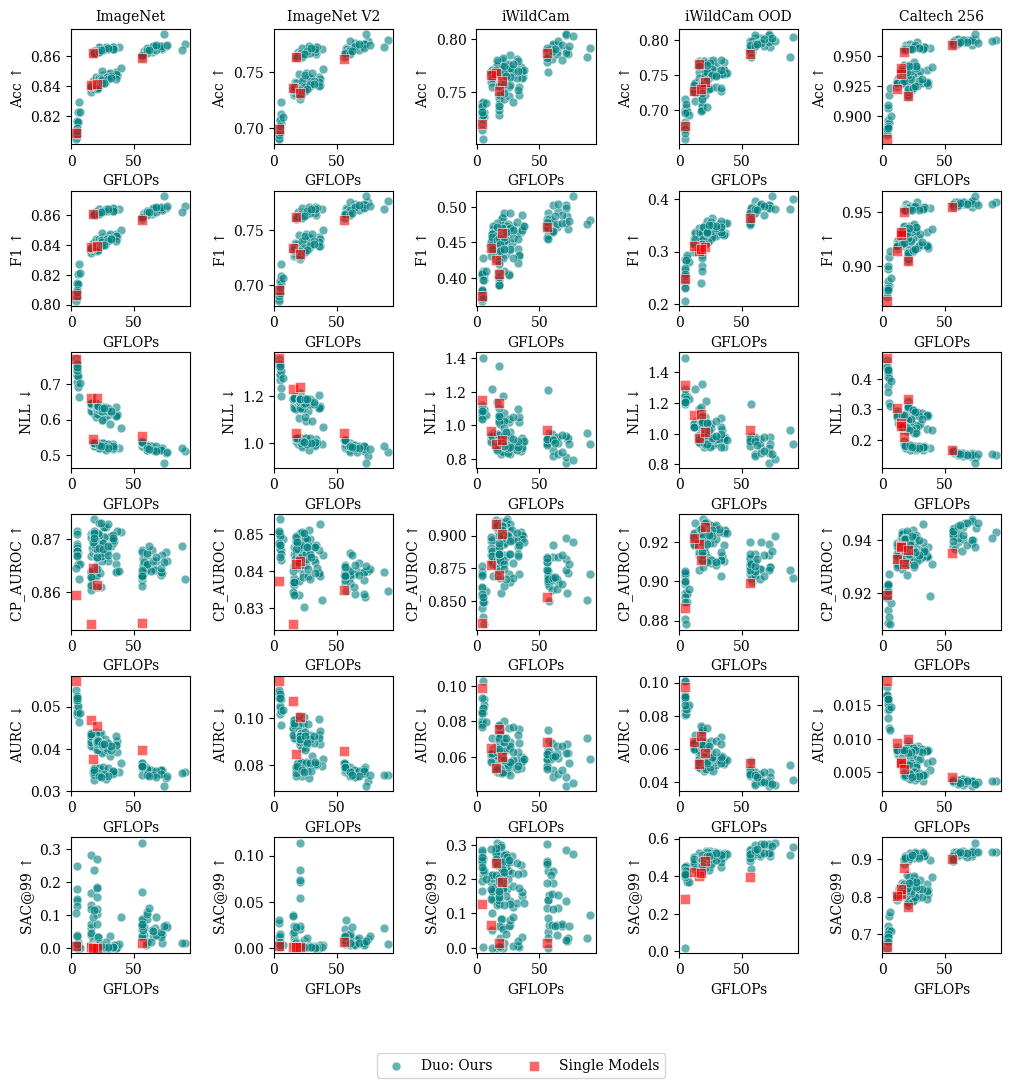

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_single_vs_duo_by_metric(
    single_model_dfs,
    duo_dfs,
    dataset_names,
    metrics,
    arrows,
    gflops_balance_min=0.2,
    gflops_balance_max=0.4,
    duo_label="Duo: Ours",
    figsize_per_row=(12, 2),
    legend_loc="lower center",
    legend_ncol=2,
    legend_offset=0
):
    num_datasets = len(dataset_names)
    num_metrics = len(metrics)

    fig, axes = plt.subplots(
        num_metrics, num_datasets,
        figsize=(figsize_per_row[0], figsize_per_row[1] * num_metrics),
        sharey=False,
        sharex=False,
        constrained_layout=False
    )
    fig.subplots_adjust(wspace=0.7, hspace=0.4)

    axes = axes if num_metrics > 1 else [axes]  # ensure 2D structure

    for row, (metric, arrow) in enumerate(zip(metrics, arrows)):
        for col, (single_df, duo_df) in enumerate(zip(single_model_dfs, duo_dfs)):
            ax = axes[row][col] if num_metrics > 1 else axes[col]
            ax.set_title(dataset_names[col] if row == 0 else "")
            ax.set_xlabel("GFLOPs")
            ax.set_ylabel(f"{metric} {arrow}")

            # Filter data
            duo_df_filtered = duo_df[
                (duo_df["gflops_balance"] > gflops_balance_min) &
                (duo_df["gflops_balance"] < gflops_balance_max) &
                (duo_df["mode"] == duo_label)
            ]
            single_df_filtered = single_df[single_df["model"].isin(duo_df_filtered["model_large"])]

            # Plot duo
            sns.scatterplot(
                data=duo_df_filtered,
                x="gflops",
                y=metric,
                ax=ax,
                label=duo_label if row == 0 and col == 0 else None,
                alpha=0.6,
                marker="o",
                color="teal",
                s=40
            )

            # Plot single
            sns.scatterplot(
                data=single_df_filtered,
                x="gflops",
                y=metric,
                ax=ax,
                label="Single Models" if row == 0 and col == 0 else None,
                alpha=0.6,
                marker="s",
                color="red",
                s=60
            )
            # ax.set_xscale("log")
        for ax_row in axes:
            for ax in (ax_row if isinstance(ax_row, (list, np.ndarray)) else [ax_row]):
                legend = ax.get_legend()
                if legend is not None:
                    legend.remove()
    # Shared legend
    handles, labels = axes[0][0].get_legend_handles_labels() if num_metrics > 1 else axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc=legend_loc,
        ncol=legend_ncol,
        bbox_to_anchor=(0.5, legend_offset)
    )


    return fig, axes


fig,_ =plot_single_vs_duo_by_metric(
    single_model_dfs,
    duo_dfs,
    dataset_names,
    metrics=["Acc", "F1", "NLL", "CP_AUROC","AURC","SAC@99",],
    arrows=["↑", "↑", "↓", "↑", "↓", "↑"],
    gflops_balance_min=0,
    gflops_balance_max=1,
)

fig.savefig("pdf/gflops_efficiency.pdf")

{'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k': 'ViT-B Clip', 'ConvNeXt_Base': 'ConvNext-B', 'tf_efficientnetv2_l.in21k_ft_in1k': 'EfficientNet-V2-L', 'Swin_V2_B': 'Swin-V2-B'}


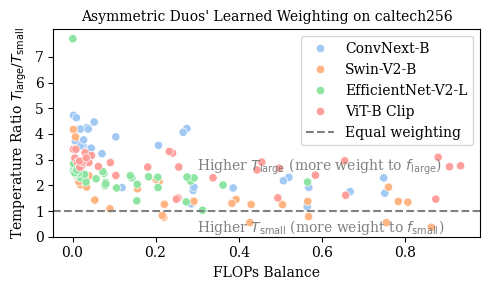

In [14]:
dataset="caltech256"
temp_single = pd.read_csv(f"temperature/temperature_single_model_{dataset}.csv")
temp_duo = pd.read_csv(f"temperature/temperature_duo_{dataset}.csv")
def assign_temperatures(row):
    temp_large = temp_single[temp_single["full_name"] == row["model_large"]]["temperature"]
    if len(temp_large) != 1:
        raise ValueError(f"Expected one match for model_large '{row['model_large']}', found {len(temp_large)}.")
    temp_small = temp_single[temp_single["full_name"] == row["model_small"]]["temperature"]
    if len(temp_small) != 1:
        raise ValueError(f"Expected one match for model_small '{row['model_small']}', found {len(temp_small)}.")
    
    return pd.Series({
        "temperature_large_independent": temp_large.values[0],
        "temperature_small_independent": temp_small.values[0],
    })

temp_duo[["temperature_large_independent", "temperature_small_independent"]] = temp_duo.apply(assign_temperatures, axis=1)
temp_duo["weight_large"]=1/(temp_duo["temperature_large"]/temp_duo["temperature_large_independent"])
temp_duo["weight_small"]=1/(temp_duo["temperature_small"]/temp_duo["temperature_small_independent"])
temp_duo["weight_ratio_los"]=temp_duo["weight_large"]/temp_duo["weight_small"]
# temp_duo["weight_ratio_absolute"]=temp_duo["temperature_small"]/temp_duo["temperature_large"]

duo_base = duo_dfs[0][["model_large", "model_small", "gflops_balance"]].copy()
duo_base = duo_base.drop_duplicates(subset=["model_large", "model_small"])

temp_duo = temp_duo.merge(
    duo_base,
    on=["model_large", "model_small"],
    how="inner",
    validate="one_to_one"
)

rename_dict={a:b for (a,b) in zip(large_models,large_model_names)}
print(rename_dict)
temp_duo["model_large_print_name"]=temp_duo["model_large"].map(rename_dict)

max_y = max(temp_duo['weight_ratio_los'])
yticks = np.arange(0, max_y + 0.2, 1)
fig, ax = plt.subplots(figsize=(5, 3))
sns.scatterplot(data=temp_duo, x="gflops_balance", y="weight_ratio_los",hue="model_large_print_name",palette="pastel",ax=ax)
plt.text(x=0.3, y=max_y/3, s="Higher $T_\mathrm{large}$ (more weight to $f_\mathrm{large}$)", fontsize=10, color="gray")
plt.text(x=0.3, y=0.2, s="Higher $T_\mathrm{small}$ (more weight to $f_\mathrm{small}$)", fontsize=10, color="gray")
plt.axhline(y=1, color="gray", linestyle="--", label="Equal weighting")
plt.title(f"Asymmetric Duos' Learned Weighting on {dataset}")
plt.yticks(yticks)
plt.xlabel("FLOPs Balance")
plt.ylabel("Temperature Ratio $T_\mathrm{large} / T_\mathrm{small}$")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("pdf/temperature_ratio.pdf")
plt.show()


In [15]:
print(temp_duo.columns)
res_duo = pd.read_csv(f"cleaned/evaluation_duo_{dataset}.csv")
res_duo = res_duo[res_duo["mode"]=="Duo: Ours"]
print(res_duo.columns)

print(f"before merge: {temp_duo.shape=}")

temp_duo_merged = temp_duo.merge(
    res_duo,
    on=["model_large", "model_small"],
    how="left",
    validate="one_to_one"
)
print(temp_duo_merged.columns)
print(f"after merge: {temp_duo_merged.shape=}")

Index(['model_large', 'model_small', 'temperature_large', 'temperature_small',
       'temperature_large_independent', 'temperature_small_independent',
       'weight_large', 'weight_small', 'weight_ratio_los', 'gflops_balance',
       'model_large_print_name'],
      dtype='object')
Index(['Acc', 'F1', 'Brier', 'NLL', 'ECE', 'CP_AUROC', 'AURC', 'E-AURC',
       'SAC@90', 'SAC@91', 'SAC@92', 'SAC@93', 'SAC@94', 'SAC@95', 'SAC@96',
       'SAC@97', 'SAC@98', 'SAC@99', 'model_large', 'model_small', 'mode',
       'wrapper', 'uncertainty_type', 'gflops_large', 'gflops_small',
       'gflops_balance', 'split', 'gflops', 'Acc_baseline', 'F1_baseline',
       'Brier_baseline', 'NLL_baseline', 'ECE_baseline', 'CP_AUROC_baseline',
       'AURC_baseline', 'E-AURC_baseline', 'SAC@90_baseline',
       'SAC@91_baseline', 'SAC@92_baseline', 'SAC@93_baseline',
       'SAC@94_baseline', 'SAC@95_baseline', 'SAC@96_baseline',
       'SAC@97_baseline', 'SAC@98_baseline', 'SAC@99_baseline',
       'model

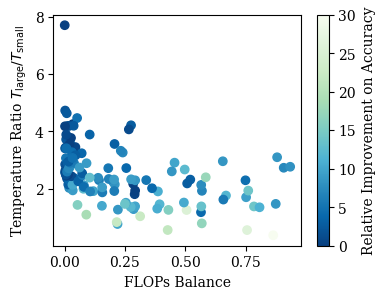

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# your data
x = temp_duo_merged["gflops_balance_y"]
y = temp_duo_merged["weight_ratio_los"]
c = temp_duo_merged["improvement_Acc"]

# set up figure
fig, ax = plt.subplots(figsize=(4, 3))

# normalize your color scale
norm = Normalize(vmin=0, vmax=30)

# do the scatter
sc = ax.scatter(
    x, y,
    c=c,
    cmap="GnBu_r",   # pick any matplotlib cmap
    norm=norm,
    alpha=1
)

# add the colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Relative Improvement on Accuracy")

# axis labels
ax.set_xlabel("FLOPs Balance")
ax.set_ylabel("Temperature Ratio $T_{\mathrm{large}} / T_{\mathrm{small}}$")

# save to file
plt.savefig("pdf/temperature_ratio_acc.pdf",bbox_inches="tight")
plt.show()


# Full Result!!!!!!!!!!!!!

In [35]:
def full_result(large_model,large_model_name,save_dir="full_pdf",duo_dfs=duo_dfs,dataset_names=dataset_names):
    extensive_result_flarge=large_model
    extensive_result_flarger_name = large_model_name
    large_models = [extensive_result_flarge]*5
    large_model_names = [extensive_result_flarger_name]*5

    fig = plot_all_datasets(
        duo_dfs=duo_dfs,
        dataset_names=dataset_names,
        large_models=large_models,
        large_model_names=large_model_names,
        metrics=["Acc","Acc","Acc","Acc","Acc"],
        metric_display_names=["Acc","Acc","Acc","Acc","Acc"],
        arrow_list=[uparrow]*5,
        scale_metric=100,
        x="gflops_balance",
        # duo_modes=['Duo: Ours','Duo: Unweighted'],
        duo_modes=['Duo: Unweighted'],
        mode_order_map=mode_order_map,
        mode_color_map=mode_color_map,
        mode_shape_map=mode_shape_map,
        mode_size_order=mode_size_order,
        annotate_xy=(0.99, 0.05),
        baseline_hue=baseline_hue,
        baseline_width=baseline_width
    )
    fig.savefig(f"{save_dir}/ACC-{extensive_result_flarge}.pdf",bbox_inches="tight")

    fig = plot_all_datasets(
        duo_dfs=duo_dfs,
        dataset_names=dataset_names,
        large_models=large_models,
        large_model_names=large_model_names,
        metrics=["F1","F1","F1","F1","F1"],
        metric_display_names=["F1","F1","F1","F1","F1"],
        arrow_list=[uparrow]*5,
        scale_metric=100,
        x="gflops_balance",
        duo_modes=['Duo: Ours','Duo: Unweighted'],
        # duo_modes=['Duo: Unweighted'],
        mode_order_map=mode_order_map,
        mode_color_map=mode_color_map,
        mode_shape_map=mode_shape_map,
        mode_size_order=mode_size_order,
        annotate_xy=(0.99, 0.05),
        baseline_hue=baseline_hue,
        baseline_width=baseline_width
    )
    fig.savefig(f"{save_dir}/F1-{extensive_result_flarge}.pdf",bbox_inches="tight")

    fig = plot_all_datasets(
        duo_dfs=duo_dfs,
        dataset_names=dataset_names,
        large_models=large_models,
        large_model_names=large_model_names,
        metrics=["NLL","NLL","NLL","NLL","NLL"],
        metric_display_names=["NLL","NLL","NLL","NLL","NLL"],
        arrow_list=[downarrow]*5,
        scale_metric=10,
        x="gflops_balance",
        duo_modes=['Duo: Ours','Duo: Unweighted'],
        mode_order_map=mode_order_map,
        mode_color_map=mode_color_map,
        mode_shape_map=mode_shape_map,
        mode_size_order=mode_size_order,
        annotate_xy=(0.99, 0.90),
        baseline_hue=baseline_hue,
        baseline_width=baseline_width
    )
    fig.savefig(f"{save_dir}/NLL-{extensive_result_flarge}.pdf",bbox_inches="tight")

    fig = plot_all_datasets(
        duo_dfs=duo_dfs,
        dataset_names=dataset_names,
        large_models=large_models,
        large_model_names=large_model_names,
        metrics=["ECE","ECE","ECE","ECE","ECE"],
        metric_display_names=["ECE","ECE","ECE","ECE","ECE"],
        arrow_list=[downarrow]*5,
        scale_metric=100,
        x="gflops_balance",
        duo_modes=['Duo: Ours','Duo: Unweighted'],
        mode_order_map=mode_order_map,
        mode_color_map=mode_color_map,
        mode_shape_map=mode_shape_map,
        mode_size_order=mode_size_order,
        annotate_xy=(0.99, 0.90),
        baseline_hue=baseline_hue,
        baseline_width=baseline_width
    )
    fig.savefig(f"{save_dir}/ECE-{extensive_result_flarge}.pdf",bbox_inches="tight")

    fig = plot_all_datasets(
        duo_dfs=duo_dfs,
        dataset_names=dataset_names,
        large_models=large_models,
        large_model_names=large_model_names,
        metrics=["Brier"]*5,
        metric_display_names=["Brier"]*5,
        arrow_list=[downarrow]*5,
        scale_metric=1e5,
        x="gflops_balance",
        duo_modes=['Duo: Ours','Duo: Unweighted'],
        mode_order_map=mode_order_map,
        mode_color_map=mode_color_map,
        mode_shape_map=mode_shape_map,
        mode_size_order=mode_size_order,
        annotate_xy=(0.99, 0.90),
        baseline_hue=baseline_hue,
        baseline_width=baseline_width
    )
    fig.savefig(f"{save_dir}/Brier-{extensive_result_flarge}.pdf",bbox_inches="tight")

    fig = plot_all_datasets(
        duo_dfs=duo_dfs,
        dataset_names=dataset_names,
        large_models=large_models,
        large_model_names=large_model_names,
        metrics=["CP_AUROC"]*5,
        metric_display_names=["AUROC"]*5,
        arrow_list=[uparrow]*5,
        scale_metric=100,
        x="gflops_balance",
        # duo_modes=['Duo: Ours','Duo: UQ Only'], # 'Duo: Unweighted'
        duo_modes=['Duo: UQ Only'], # 'Duo: Unweighted'
        mode_order_map=mode_order_map,
        mode_color_map=mode_color_map,
        mode_shape_map=mode_shape_map,
        mode_size_order=mode_size_order,
        annotate_xy=(0.99, 0.05),
        baseline_hue=baseline_hue,
        baseline_width=baseline_width
    )
    fig.savefig(f"{save_dir}/AUROC-{extensive_result_flarge}.pdf",bbox_inches="tight")

    fig = plot_all_datasets(
        duo_dfs=duo_dfs,
        dataset_names=dataset_names,
        large_models=large_models,
        large_model_names=large_model_names,
        metrics=["AURC"]*5,
        metric_display_names=["AURC"]*5,
        arrow_list=[downarrow]*5,
        scale_metric=100,
        x="gflops_balance",
        # duo_modes=['Duo: Ours','Duo: UQ Only'],
        duo_modes=['Duo: Ours'], # 'Duo: Unweighted', 'Duo: Ours','Duo: UQ Only'
        mode_order_map=mode_order_map,
        mode_color_map=mode_color_map,
        mode_shape_map=mode_shape_map,
        mode_size_order=mode_size_order,
        annotate_xy=(0.99, 0.90),
        baseline_hue=baseline_hue,
        baseline_width=baseline_width
    )
    fig.savefig(f"{save_dir}/AURC-{extensive_result_flarge}.pdf",bbox_inches="tight")

    fig = plot_all_datasets(
        duo_dfs=duo_dfs,
        dataset_names=dataset_names,
        large_models=large_models,
        large_model_names=large_model_names,
        metrics=["SAC@98"]*5,
        metric_display_names=["SAC@98"]*5,
        arrow_list=[uparrow]*5,
        scale_metric=100,
        x="gflops_balance",
        # duo_modes=['Duo: Ours','Duo: UQ Only'],
        duo_modes=['Duo: Ours'], # 'Duo: Unweighted'
        mode_order_map=mode_order_map,
        mode_color_map=mode_color_map,
        mode_shape_map=mode_shape_map,
        mode_size_order=mode_size_order,
        annotate_xy=(0.99, 0.05),
        baseline_hue=baseline_hue,
        baseline_width=baseline_width
    )
    fig.savefig(f"{save_dir}/SAC@98-{extensive_result_flarge}.pdf",bbox_inches="tight")

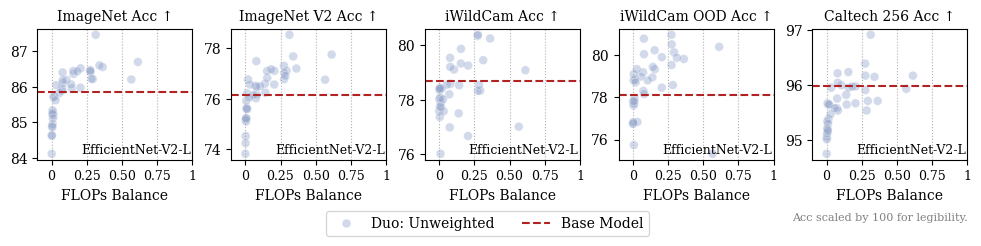

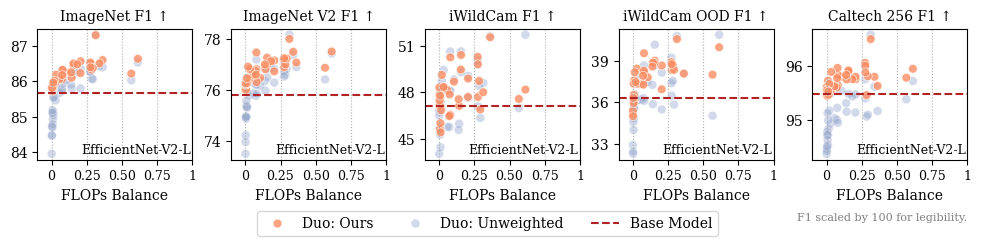

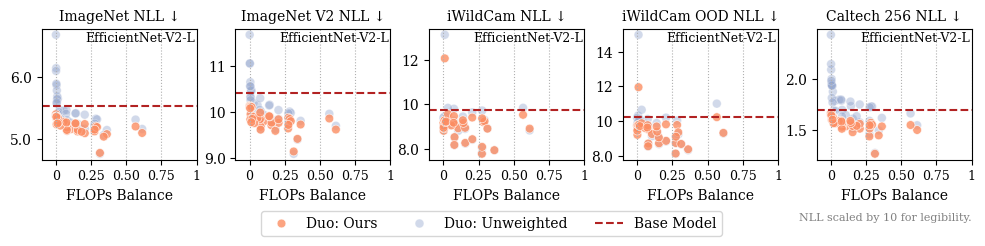

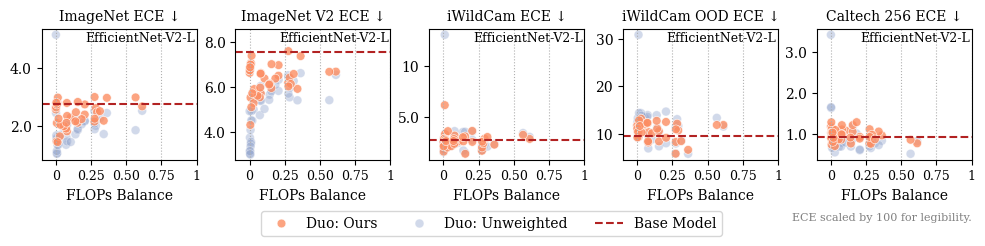

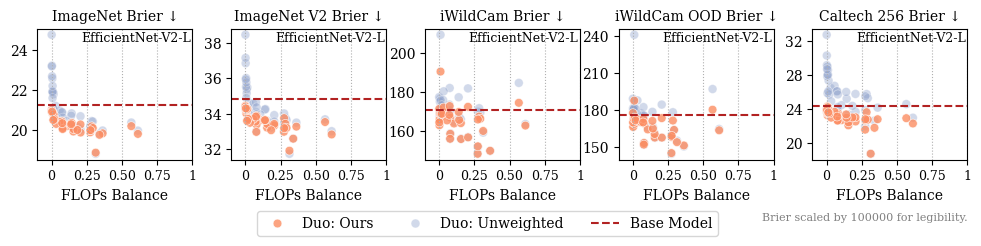

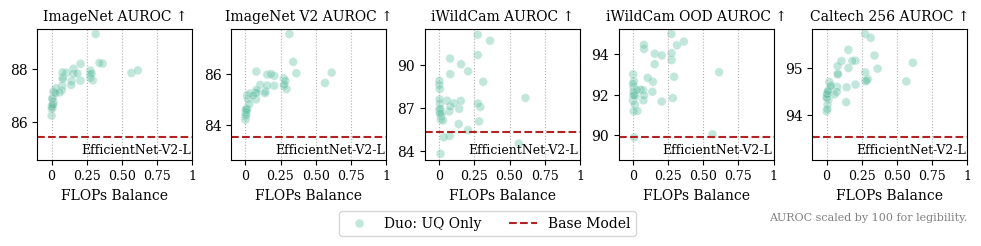

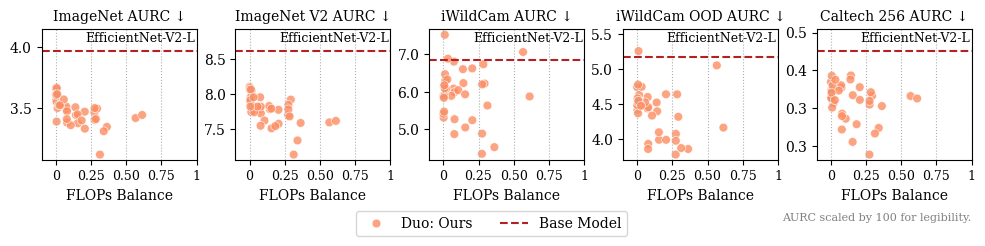

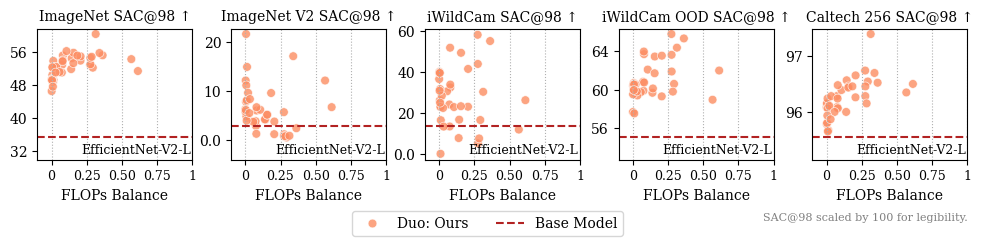

In [36]:
# full_result("vit_base_patch16_clip_224.laion2b_ft_in12k_in1k","ViT-B Clip")
full_result("tf_efficientnetv2_l.in21k_ft_in1k","EfficientNet-V2-L")
# full_result("Swin_V2_B","Swin-V2-B")
# full_result("ConvNeXt_Base","ConvNext-B")
